## Data Processing

In [19]:
import pandas as pd
import numpy as np
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
import shap
import time
import matplotlib.pyplot as plt

In [20]:
def get_direction(playDescription):
        if("left" in playDescription):
                return 0
        if("right" in playDescription):
                return 2
        return 1

In [21]:
# load dataframes
games = pd.read_csv("data/games.csv")
plays = pd.read_csv("data/plays.csv")
tackles = pd.read_csv("data/tackles.csv")
players = pd.read_csv("data/players.csv")


In [22]:
# add target var (can also use play desc to count scrambles as runs)
plays["run"] = plays["passResult"].isna()

In [23]:
#makes column for if run(1 true, 0 false)
plays["run"] = plays["passResult"].isna()
#makes column for play direction
plays["direction"] = plays["playDescription"].apply(get_direction)
#filters play data
plays_filtered = plays[["gameId","quarter", "down", "yardsToGo", "possessionTeam","defensiveTeam","absoluteYardlineNumber", "gameClock", "preSnapHomeScore",
                        "preSnapVisitorScore", "offenseFormation", "defendersInTheBox","run","direction"]]

In [24]:
#filters game data
games_filtered = games[["gameId", "week","gameTimeEastern"]]

In [25]:
# filter players dataframe
players_filtered = players[["position", "nflId"]]

In [26]:
#combine game data with play data
data = plays_filtered.merge(games_filtered, on="gameId")

In [27]:
#make all game times purly numbers (probably not necessary - most models can handle datetime or can convert to int differently)
def str_to_time(time):
    splt = time.split(":")
    return int(splt[0]) * 60 + int(splt[1])
data["gameTimeEastern"] = data["gameTimeEastern"].apply(str_to_time)
data["gameClock"] = data["gameClock"].apply(str_to_time)
#drop game id
data.drop("gameId",axis =1, inplace=True)
#normalization]
for param in ['yardsToGo','absoluteYardlineNumber',	'gameClock', 'week','preSnapHomeScore',	'preSnapVisitorScore',	'defendersInTheBox','gameTimeEastern']:
    data[param] = (data[param] - data[param].mean())/data[param].std()
    



In [28]:
#find all unique teams
teams = data.possessionTeam.unique()
#1 hot encode teams and formations
data = pd.get_dummies(data, prefix=['possessionTeam', 'defensiveTeam', 'offenseFormation'])
#fill 1 nan in defeive players in the box
data.fillna(0,inplace=True)

In [29]:
#empty dictionary of team names
data_by_team_test = {x : pd.DataFrame() for x in teams}
data_by_team_train = {x : pd.DataFrame() for x in teams}
data_test = pd.DataFrame()
data_train = pd.DataFrame()
#fills dictionary with all plays according to possesion team
for team in teams:
    data_by_team_test[team] = data[data["possessionTeam_"+str(team)]]
    #seperate into train and test sets seperated by team 
    rows = len(data_by_team_test[team])
    rand_idx = np.random.randint(0, rows,size = int(rows/10))
    #make seperate train and test sets for each team
    data_by_team_train[team] = data_by_team_test[team].drop(data_by_team_test[team].index[rand_idx])
    data_by_team_test[team] = data_by_team_test[team].iloc[rand_idx]
    #create a joined train and test set(for overall)
    data_test = pd.concat([data_test, data_by_team_test[team]], ignore_index = True)
    data_train = pd.concat([data_train, data_by_team_train[team]], ignore_index = True)

#Randomize final sets to mix teams
data_test = data_test.sample(frac=1)
data_train = data_train.sample(frac=1)
#split datasets into parameters and result
data_test_run = data_test["run"]
#data_test_epa = data_test["expectedPoints"]
data_test_dir = data_test["direction"]
data_test.drop(["run","direction"],axis =1, inplace=True)

data_train_run = data_train["run"]
#data_train_epa = data_train["expectedPoints"]
data_train_dir = data_train["direction"]
data_train.drop(["run","direction"],axis =1, inplace=True)

data_test

,quarter,down,yardsToGo,absoluteYardlineNumber,gameClock,preSnapHomeScore,preSnapVisitorScore,defendersInTheBox,week,gameTimeEastern,...,defensiveTeam_TB,defensiveTeam_TEN,defensiveTeam_WAS,offenseFormation_EMPTY,offenseFormation_I_FORM,offenseFormation_JUMBO,offenseFormation_PISTOL,offenseFormation_SHOTGUN,offenseFormation_SINGLEBACK,offenseFormation_WILDCAT
580,4,3,3.190365,-0.686787,1.709341,0.299652,0.671278,-0.417929,-0.339647,-1.902647,...,False,False,False,False,False,False,False,True,False,False
590,4,1,2.935765,-0.561355,1.709341,1.041017,0.999423,-0.417929,0.051646,-0.733174,...,False,False,False,False,False,False,False,True,False,False
962,3,1,0.389770,-1.481192,-0.881565,-0.547622,-0.313156,-0.417929,1.225526,0.408454,...,False,False,False,False,False,False,True,False,False,False
124,1,1,0.389770,0.483915,-0.780621,-0.865350,-0.313156,-0.417929,-0.730940,-0.733174,...,False,False,False,False,False,False,False,True,False,False
352,2,1,0.389770,1.738238,1.462588,-1.183078,-1.078827,0.567556,-1.513527,-0.733174,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
670,4,1,0.389770,0.023996,1.709341,-0.441713,0.014989,0.567556,-1.513527,-0.733174,...,False,False,False,False,True,False,False,False,False,False
871,3,1,0.389770,-1.063084,0.539134,0.299652,1.436949,0.567556,0.834232,1.689305,...,False,False,False,False,False,False,False,False,True,False
313,2,2,-0.883228,1.069265,-0.268421,-0.123985,-0.313156,-0.417929,0.051646,-0.733174,...,False,False,True,False,False,False,False,True,False,False
308,3,4,-1.901626,2.030913,-0.182432,-0.865350,-0.313156,2.538528,1.225526,0.297076,...,False,False,False,False,True,False,False,False,False,False


Covert all to NP arrays incase this makes Custum Regression Easier

In [30]:
data_test_run = np.ravel(np.array(data_test_run))
#data_test_epa = np.ravel(np.array(data_test_epa))
data_test_dir = np.ravel(np.array(data_test_dir))
data_test_param = np.array(data_test)

data_train_run = np.ravel(np.array(data_train_run))
#data_train_epa = np.ravel(np.array(data_train_epa))
data_train_dir = np.ravel(np.array(data_train_dir))
data_train_param = np.array(data_train)

Random Forest

In [31]:
# initial random forest classifier
clf = RandomForestClassifier(random_state=28)

In [32]:
clf.fit(data_train, data_train_run)

RandomForestClassifier(random_state=28)

In [33]:
preds = clf.predict(data_test)

In [34]:
acc = (preds == data_test_run).sum() / len(preds) * 100


## Hyperparameter Tuning

In [35]:
estimators = [50, 100, 200, 400]
depth = [None, 10, 20, 30]
param = ["gini", "entropy"]
res = []
for estimator in estimators:
    for d in depth:
        for p in param:
            clf = RandomForestClassifier(n_estimators=estimator, max_depth=d, criterion=p, random_state=28)
            clf.fit(data_train, data_train_run)
            preds = clf.predict(data_test)
            acc = (preds == data_test_run).sum() / len(preds)
            res.append({
              "n_estimators":estimator, "max_depth":d, "criterion":p, "accuracy":acc*100  
            })
results = pd.DataFrame(res)

In [36]:
# top 10 after tuning (difference is relatively negligible)
results.sort_values(by="accuracy",ascending=False).iloc[:10]

,n_estimators,max_depth,criterion,accuracy
29,400,20.0,entropy,74.858070
1,50,NaN,entropy,74.776967
28,400,20.0,gini,74.614761
12,100,20.0,gini,74.533658
20,200,20.0,gini,74.452555
21,200,20.0,entropy,74.452555
13,100,20.0,entropy,74.290349
17,200,NaN,entropy,74.128143
25,400,NaN,entropy,73.884834
9,100,NaN,entropy,73.803731


## Best Model Deep Dive

In [37]:
clf = RandomForestClassifier(n_estimators=200, max_depth=30, criterion="gini", random_state=28)
clf.fit(data_train, data_train_run)
preds = clf.predict(data_test)
acc = (preds == data_test_run).sum() / len(preds) * 100
acc

73.56042173560422

<Axes: >

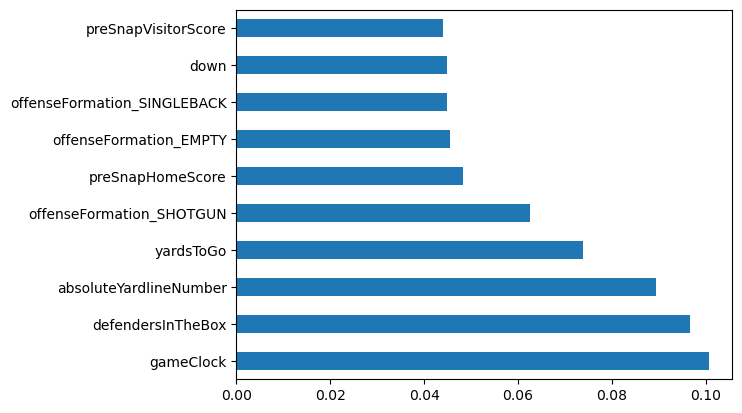

In [38]:
# plot top 10 feature importances
feat_importances = pd.Series(clf.feature_importances_, index=data_train.columns)
feat_importances.nlargest(10).plot(kind='barh')

In [40]:
# work in progress still
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(data_test)
#shap.summary_plot(shap_values[1], data_test)

In [45]:
shap_values.shape
data_test.shape

(1233, 81)

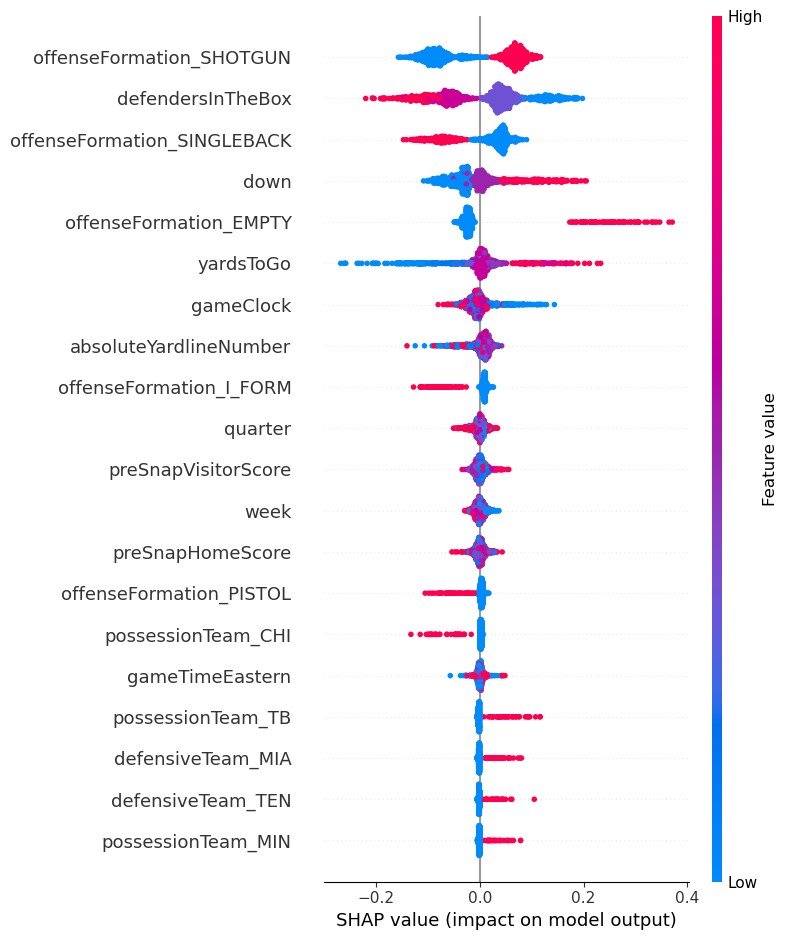

In [47]:
shap.summary_plot(shap_values[:,:,0], data_test)

## Team Specific Analysis

In [ ]:
# testing all teams on the same model
start = time.time()
clf = RandomForestClassifier(n_estimators=200, max_depth=30, criterion="gini", random_state=28)
clf.fit(data_train, data_train_run)
accs1 = {}
for team in data_by_team_test.keys():
    actual = data_by_team_test[team]["run"]
    preds = clf.predict(data_by_team_test[team].drop(columns=["run", "direction"]))
    acc = (preds == actual).sum() / len(preds) * 100
    accs1[team] = acc
end = time.time()
print("time taken: " + str(end-start) + " seconds")
print("average accuracy (unweighted): " + str(sum(accs1.values()) / len(accs1.values())) + "%")

time taken: 7.5084710121154785 seconds
average accuracy (unweighted): 74.59852268308329%


In [ ]:
# new model for each team
start = time.time()
accs = []
for team in data_by_team_test.keys():
    clf = RandomForestClassifier(n_estimators=200, max_depth=30, criterion="gini", random_state=28)
    y_train = data_by_team_train[team]["run"]
    X_train = data_by_team_train[team].drop(columns=["run", "direction"])
    clf.fit(X_train, y_train)
    actual = data_by_team_test[team]["run"]
    preds = clf.predict(data_by_team_test[team].drop(columns=["run", "direction"]))
    acc = (preds == actual).sum() / len(preds) * 100
    accs.append(acc)
end = time.time()
print("time taken: " + str(end-start) + " seconds")
print("average accuracy (unweighted): " + str(sum(accs) / len(accs)) + "%")

time taken: 37.20807504653931 seconds
average accuracy (unweighted): 71.13776217184322%


<BarContainer object of 32 artists>

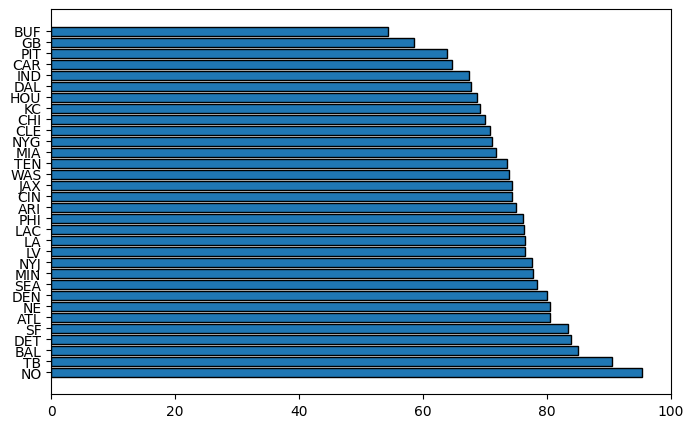

In [ ]:
# look at best teams
teams_acc = sorted(accs1.items(), key=lambda x: x[1], reverse=True)
teams = [team for team, accuracy in teams_acc]
accuracies = [accuracy for team, accuracy in teams_acc]
plt.figure(figsize=(8, 5)) 
plt.barh(teams, accuracies, edgecolor='black')

Linear Regression

In [ ]:
model = LinearRegression()
model.fit(data_train_param, data_train_run)
pass_pred = model.predict(data_test_param)
pass_pred = np.where(pass_pred>.5,1,0)
matching = np.sum(pass_pred == data_test_run)
#percentage accuarcy
matching/len(pass_pred) * 100

74.29034874290349